## File to create alternate definition of commercial
Jameson Carter

purpose: To recompute the number of commercial buildings according to the zoning maps- this came from the realization that many apartment buildings are listed as commercial in the input data when they are not.

input: pittsburgh_footprint.shp
       sourced from:
       https://openac-alcogis.opendata.arcgis.com/datasets/AlCoGIS::allegheny-county-building-footprint-locations/explore?filters=eyJDTEFTUyI6WyJSIl19&location=40.462063%2C-79.916146%2C16.82
       and city of Pittsburgh 2010 census tract boundaries: https://data.wprdc.org/dataset/2010-census-tracts; additionally we using the zoning map from WPRDC: https://data.wprdc.org/dataset/zoning/resource/58428979-645f-413e-83b5-f06686c40959?inner_span=True
       
pittsburgh_footprint.shp merged from 'Filter footprints for Pittsburgh.ipynb'
       
output: pittsburgh_footprint_clean.shp

In [2]:
import geopandas as gpd
import pandas as pd
#import folium
import matplotlib.pyplot as plt

In [3]:
footprint = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/pittsburgh_footprint.shp')

In [4]:
zones = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Zoning.shp')

In [5]:
commercial = zones.loc[zones['legendtype'].isin(['Local Neighborhood Commercial', 'Highway Commercial', 'Urban Neighborhood Commercial'])]
commercial = commercial[['geometry','legendtype']]

In [6]:
footprint_commercial = footprint.sjoin(commercial, how="left", predicate='intersects')
footprint_commercial['CLASS'].unique()

array(['C', 'R', 'G', 'U', 'I', 'F', 'O', None, 'None'], dtype=object)

What I need from the below is the following: a re-coded class for these footprints such that only those WITHIN commercial zoning boundaries count as commercial.

Going to recode them from commercial to 'maybe_commercial_or_apartment'

In [7]:
footprint_commercial['class_recode'] = footprint_commercial['CLASS'] # Base the variable off of class, to begin with
# Note that the recode flags commercial buildings not located in the relevant areas as maybe commercial or apartment
# This is to reflect the ambiguity in the data. Apartments will come later...
footprint_commercial.loc[footprint_commercial['class_recode'] == 'C', 'class_recode'] = 'maybe_commercial_or_apartment' # start with baseline commercial classification
footprint_commercial.loc[footprint_commercial['legendtype'].isin(['Local Neighborhood Commercial', 'Highway Commercial', 'Urban Neighborhood Commercial']), 'class_recode'] = 'commercial'
footprint_commercial.loc[footprint_commercial['class_recode'] == 'R', 'class_recode'] = 'residential'


# Let's see shadyside now, for all buildings
plt.rcParams["figure.figsize"]=20,20
shady_all = footprint_commercial.loc[(footprint_commercial['hood']== 'Shadyside')]
#residential.columns
shady_commercial.plot(column='class_recode', legend = True)

NameError: name 'shady_commercial' is not defined

In [ ]:
# pittsburgh_footprint_clean.to_file("C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/pittsburgh_footprint_clean.shp")
# Get assets table and turn it into something geographic
assets_pre = pd.read_csv('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Allegheny_county_assets.csv')
assets = gpd.GeoDataFrame(
    assets_pre, geometry=gpd.points_from_xy(assets_pre.longitude, assets_pre.latitude)
).set_crs(4326, allow_override=True)
# Get apartments
assets = assets[['name','latitude','longitude','asset_type','geometry','city']]
apartments = assets.loc[assets['asset_type'].isin(['affordable_housing','apartment_buildings'])]
apartments

C:\Users\jacar\AppData\Local\Temp\ipykernel_34748\3096405282.py:3: DtypeWarning: Columns (2,7,16,19,20,24,28,29,41) have mixed types. Specify dtype option on import or set low_memory=False.
  assets_pre = pd.read_csv('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Allegheny_county_assets.csv')


,name,latitude,longitude,asset_type,geometry,city
0,TARENTUM SENIOR HOUSING aka Daltons Edge,40.603461,-79.745422,affordable_housing,POINT (-79.74542 40.60346),Tarentum
1,SWISSVALE TOWERS,40.422258,-79.890644,affordable_housing,POINT (-79.89064 40.42226),Pittsburgh
2,SWEETBRIAR PLACE,40.437915,-80.021735,affordable_housing,POINT (-80.02174 40.43791),Pittsburgh
3,SUSQUEHANNA HOMES,40.453754,-79.896327,affordable_housing,POINT (-79.89633 40.45375),Pittsburgh
4,STO-ROX PLAZA,40.441914,-80.038494,affordable_housing,POINT (-80.03849 40.44191),Pittsburgh
...,...,...,...,...,...,...
31500,WOODCREST RETIREMENT RESIDENCE,40.502866,-80.155820,affordable_housing,POINT (-80.15582 40.50287),Coraopolis
31501,WYLIE AVENUE TOWNHOMES,40.444727,-79.979702,affordable_housing,POINT (-79.97970 40.44473),Pittsburgh
31502,YESTER SQUARE,40.352082,-79.844692,affordable_housing,POINT (-79.84469 40.35208),Mckeesport
31503,YORK COMMONS,40.465293,-79.957390,affordable_housing,POINT (-79.95739 40.46529),Pittsburgh


In [ ]:
# Maybe we some footprints classified as residential are not residential?
print(footprint_commercial.columns)
footprint_commercial = footprint_commercial.drop(columns=['index_right'])
apt_with_allbuilding = footprint_commercial.sjoin(apartments, how="left", predicate='intersects') 
apt_with_allbuilding
# next, check to see why

Index(['OBJECTID', 'status', 'prev_area', 'pct_change', 'CLASS', 'LUC',
       'FEATURECOD', 'ShapeSTAre', 'ShapeSTLen', 'index_righ', 'objectid_1',
       'statefp10', 'countyfp10', 'tractce10', 'blkgrpce10', 'geoid10',
       'namelsad10', 'mtfcc10', 'funcstat10', 'aland10', 'awater10',
       'intptlat10', 'intptlon10', 'hood', 'hood_no', 'acres', 'sqmiles',
       'sectors', 'tract', 'cdbg2014', 'tracttext', 'objectid_2', 'tractce10_',
       'cnt_tractc', 'sum_lowmod', 'sum_lowm_1', 'lowmodperc', 'lowmodpe_1',
       'cdbg2018', 'Shape__Are', 'Shape__Len', 'geometry', 'index_right',
       'legendtype', 'class_recode'],
      dtype='object')


,OBJECTID,status,prev_area,pct_change,CLASS,LUC,FEATURECOD,ShapeSTAre,ShapeSTLen,index_righ,...,Shape__Len,geometry,legendtype,class_recode,index_right,name,latitude,longitude,asset_type,city
0,30357,existing,0.0,0.0,C,480,220.0,3327.113159,235.679307,67,...,23650.358220,"POLYGON ((-80.01230 40.38309, -80.01255 40.383...",NaN,maybe_commercial_or_apartment,NaN,NaN,NaN,NaN,NaN,NaN
1,32746,existing,0.0,0.0,R,10,210.0,894.295807,141.440947,67,...,23650.358220,"POLYGON ((-80.01382 40.38638, -80.01380 40.386...",NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN
2,52206,existing,0.0,0.0,R,10,210.0,1691.813782,184.622744,67,...,23650.358220,"POLYGON ((-80.01309 40.38253, -80.01307 40.382...",NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN
3,104248,existing,0.0,0.0,R,10,250.0,1468.409760,174.336765,67,...,23650.358220,"POLYGON ((-80.01399 40.38554, -80.01399 40.385...",NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN
4,108081,existing,0.0,0.0,R,10,250.0,1545.470551,177.040457,67,...,23650.358220,"POLYGON ((-80.00736 40.38204, -80.00729 40.381...",NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117598,567340,existing,0.0,0.0,G,660,NaN,348.586243,84.663145,121,...,18179.243394,"POLYGON ((-79.91503 40.43021, -79.91492 40.430...",NaN,G,NaN,NaN,NaN,NaN,NaN,NaN
117599,568073,existing,0.0,0.0,R,10,250.0,1799.898376,175.911675,121,...,18179.243394,"POLYGON ((-79.91190 40.43303, -79.91190 40.433...",NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN
117600,569910,existing,0.0,0.0,G,660,250.0,1759.203918,264.463667,121,...,18179.243394,"POLYGON ((-79.91355 40.42945, -79.91381 40.429...",NaN,G,NaN,NaN,NaN,NaN,NaN,NaN
117601,571013,existing,0.0,0.0,R,100,250.0,1338.227112,163.217725,121,...,18179.243394,"POLYGON ((-79.91393 40.43209, -79.91394 40.432...",NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
apt_with_allbuilding.columns
apt_with_allbuilding.loc[(apt_with_allbuilding['asset_type'].isin(['affordable_housing','apartment_buildings'])),
 'class_recode'] = 'apartment' # recode questionable buildings with this

NameError: name 'apt_with_allbuilding' is not defined

<AxesSubplot:>

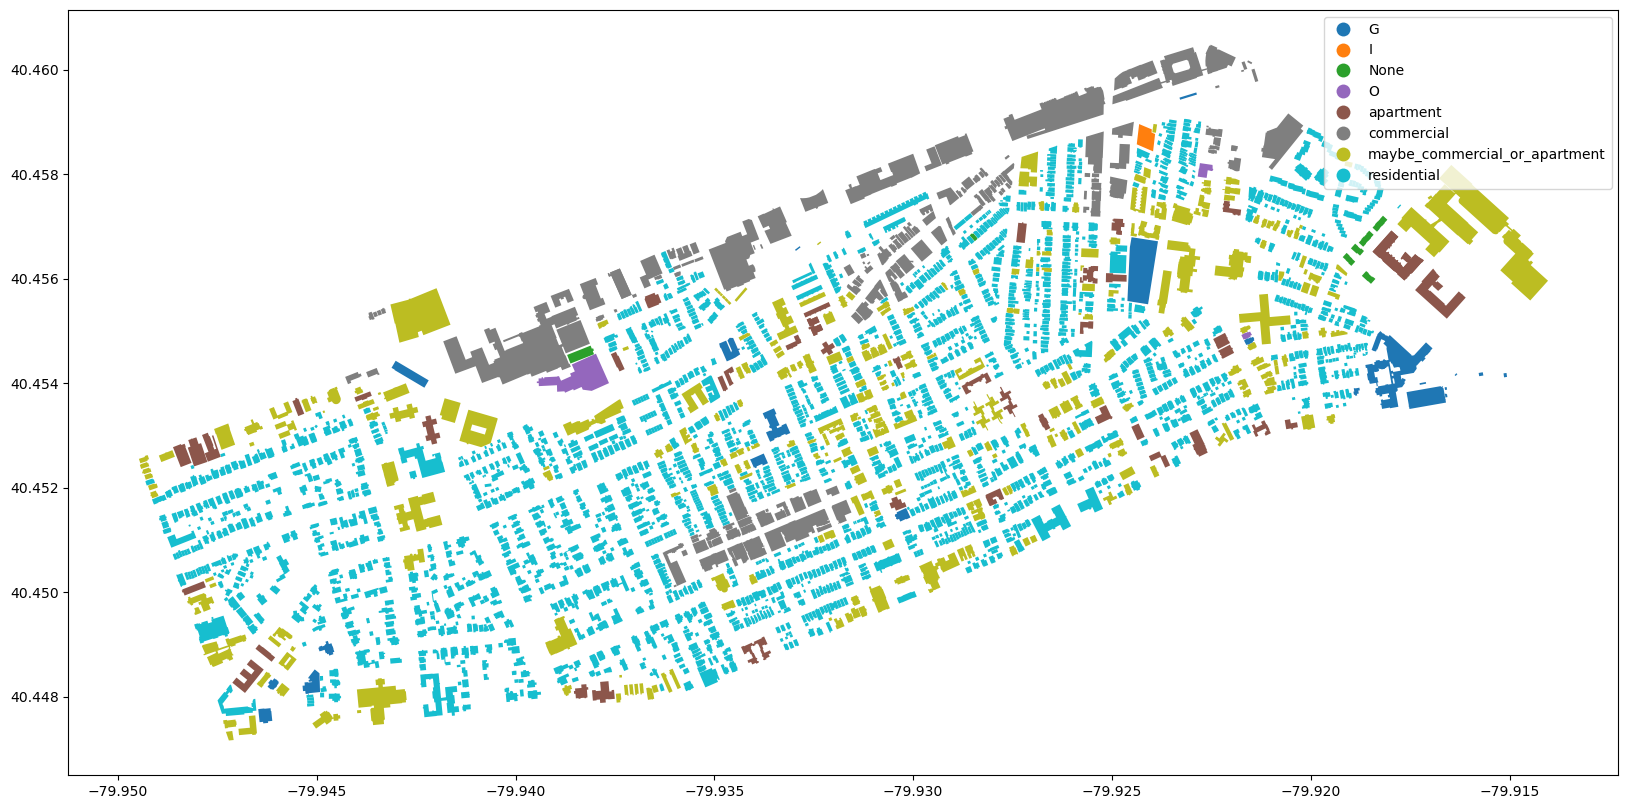

In [ ]:
# Let's see shadyside now, for all buildings
plt.rcParams["figure.figsize"]=20,20
shady_all = apt_with_allbuilding.loc[(apt_with_allbuilding['hood']== 'Shadyside')]
#residential.columns
shady_all.plot(column='class_recode', legend = True)